# ALS transect 3D visualization

This notebook illustrates transect visualization using CVL 3D Viz software


## Objectives

Demonstrate visualization of X,Y,Z timeseries together with the Sentinel-1 image as background

## Prerequisites

Software prerequisites
- pip3
- cvl 3d viz library
- requests
- pyresample
- pandas
- geopandas
- pillow

System libraries not provided via CVL have been installed using conda/mamba package manager.

Install CVL 3D viz library for steering the visualization in-browser app 


```
# Use preceeding exclamation mark if installing from within the notebook, othewise add URL below to requirements file
!pip3 install git+https://github.com/CryosphereVirtualLab/cvl-3d-viz#egg=cvl-3d-viz
```

To access the visualizer open https://cvl.eo.esa.int/.


In [1]:
import numpy

In [2]:
#!pip3 install git+https://github.com/CryosphereVirtualLab/cvl-3d-viz#egg=cvl-3d-viz > /dev/null 2>&1
#!pip3 install pillow > /dev/null 
#!pip install pyresample > /dev/null 2>&1
#!pip install pyproj

## Starting CVL 3d Viz server
The server is necessary to communicate between the notebook and the browser application. The server needs to be available, configured and running locally.


In [3]:
# Obtain 3d viz server code
!if [ ! -d ./cvl-3d-viz ]; then git clone https://github.com/CryosphereVirtualLab/cvl-3d-viz.git ./cvl-3d-viz ; fi

# add cvl to path
import os
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.curdir),"cvl-3d-viz"))

import subprocess

Generate new keys for SSL config

In [4]:
subprocess.Popen("openssl req -x509 -nodes -days 730 -newkey rsa:2048 -keyout key.pem -out cert.pem -config cvl-3d-viz/cvl/localhost-ssl.conf", shell=True)

Generating a RSA private key
....

<Popen: returncode: None args: 'openssl req -x509 -nodes -days 730 -newkey r...>

..

Start server

In [5]:
subprocess.Popen("nohup python cvl-3d-viz/cvl/server.py > /dev/null 2>&1 &", shell=True)

....

<Popen: returncode: None args: 'nohup python cvl-3d-viz/cvl/server.py > /dev...>

..

__INFO__: you might need to open and trust the following link: https://localhost:3193/trust

In [6]:
from cvl.viz import viz, VBO, Raster
visualizer = viz()
# visualizer.look_at([70, 70, 5000], [1, 69.673, 0], 100)

....+++++
..................+++++
writing new private key to 'key.pem'
-----


# Input data

Data series come in tabular format and represent geographical coordinates and height. Data are hosted at Zenodo and need to be cached locally before executing the rest of the playbook. Additionally Sentinel-1 scenes are used as a background and those are added

We will pull the data zip file using requests library and unpack it locally for further use.

*__NOTE__: Make sure the following is a code cell when running playbook. By default it is set to raw nbconvert format, so execution of the cell is skipped.*

## Extract the contents of the ZIP archive

*__NOTE__: Make sure the following is a code cell when running playbook. By default it is set to raw nbconvert format, so execution of the cell is skipped.*

#  Load 1D measurements as Geopandas DataFrame
Here our approach is to use pandas to load data from the CSV file we obtained earlier. Once the series are loaded we create geopandas data frame object which add geospatial dimension to the series by creating geometry column.

Geopandas provides methods for casting the geometry information into the desired coordinate system/projection. Here we use UTM 33N, as it is used in the original CVL 3D viz example notebook.

In [7]:
# Source data contains white spaces in the header, we want to skip them on loading for easier indexing later
import pandas
df = pandas.read_csv("data/transect_latlon.txt", skipinitialspace=True)

In [8]:
import geopandas as gpd
# Create a geometry aware Geopandas DataFrame object 
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Lon, df.Lat),
    crs=4326
).to_crs(32633)

# Plot data using 3D Viz

Functions below are taken from the original 3D viz example notebook. Alternative would be to generate a geojson object since 3D viz has methods for processing geojson files/objects.

In [9]:
# This helper function was taken from the 3D Viz example notebook
def post_3d_data(key, primitive, vertices, color=None, texcoord=None, normal=None, index=None, texture=None, compute_normals=False):
    # metadata = { "path" : "Examples", "time_start" : time.time()-601, "time_stop" : time.time()-601 }
    metadata = { "path" : "ALS" }
    vbo = VBO(primitive, projection=32633)
    vbo.compute_normals = compute_normals
    vbo.set_vertex(vertices)
    vbo.set_color(color)
    vbo.set_texcoord(texcoord)
    vbo.set_normal(normal)
    vbo.set_index(index)
    vbo.texture = texture
    visualizer.publish_vbo(key, metadata, vbo)

In [10]:
# Display transect measurements

import numpy as np
import math

points = np.array([x for x in zip(gdf.geometry.x, gdf.geometry.y, gdf["Total thickness (m)"]) ])
colors = np.ones((points.shape[0],4), dtype=np.uint32) * (255, 255, 255, 255)
vcolors = np.array([VBO.rgb_to_color(x[0], x[1], x[2], x[3]) for x in colors], dtype=np.uint32)

# Post transect data as points to web app
post_3d_data("Transect points", "points", points, vcolors);

## Screenshot from 3D Viz with the result

Picture below illustrates the results of plotting the transect points data (to access the visualizer open https://cvl.eo.esa.int/). Points have 3 dimensions and when zooming in a difference in height is noticeable.

![title](./res/screenshot.png)

# Load Sentinel-1 satellite data

Satellite measurements are provided on a irregular grid and come in the shape of a 1D array. To create an image we resample them on the grid using `pyresample` package. Resulting raster array is then added to the CVL 3D Viz.

In [11]:
# Load the data and create a regular image grid
from pyresample import geometry, image, kd_tree

In [12]:
df = pandas.read_csv("data/S1_20200313T114854_intensityHH_latlon.txt", skipinitialspace=True)
data = df["Intensity HH (dB)"].to_numpy()
# y dimension was guess by looking at the location of the drops of the monotonously rising longitude values
shape = (1763, int(df.Lat.shape[0]/1763))
lats = df.Lat.to_numpy().reshape(shape)
lons = df.Lon.to_numpy().reshape(shape)
data = df["Intensity HH (dB)"].to_numpy().reshape(shape)

## Resampling
---

We use EPSG 32633 to put geographic coordinates on the regular grid. Grid definition is done by the AreaDefinition object and it takes corner coordinates to define extent. Then data is resampled using gaussian method. Normalized DN values are plotted to illustrate resampling results.

/home/yannick/anaconda3/envs/cvl-polona/lib/python3.10/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 8 neighbours within 1000 m for some data points
  warnings.warn(('Possible more than %s neighbours '


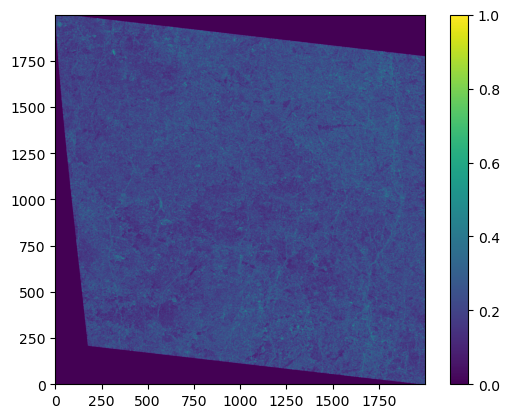

In [13]:
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
transformer = Transformer.from_crs(4326, 32633, always_xy=True)
lonx, latx = transformer.transform(lons, lats)
swath_def = geometry.SwathDefinition(lats=lats.ravel(), lons=lons.ravel())
area_def = geometry.AreaDefinition.from_extent(
    "ALS",
    32633,
    (2000,2000),
    (
        lonx[0,0], latx[0,0],
        lonx[1762,1958], latx[1762,1958]
    )
)
res = kd_tree.resample_gauss(swath_def, data.ravel(), area_def, radius_of_influence=1000, sigmas=5)
plt.imshow((res-res.min())/(res.max()-res.min()), origin='lower'); plt.colorbar()


In [14]:
# Convert numpy array to binary image
from PIL import Image
# Normalize and scale to 255 before saving
im = Image.fromarray(np.uint8((res-res.min())/(res.max()-res.min())*255))
im.save("res/out.png")

# Add projected Sentinel-1 data as transect background

In [15]:
# Define image boundaries
img_points = []
img_points.append([area_def.projection_x_coords[0], area_def.projection_y_coords[0]])
img_points.append([area_def.projection_x_coords[-1], area_def.projection_y_coords[0]])
img_points.append([area_def.projection_x_coords[0], area_def.projection_y_coords[-1]])
img_points.append([area_def.projection_x_coords[-1], area_def.projection_y_coords[-1]])

# Load raster data
with open("res/out.png", "rb") as fd:
    texture = fd.read()

raster = Raster(img_points, [2,2], 32633, image_data=texture)
metadata = { "path" : "ALS" }
visualizer.publish_raster("Test image", metadata, raster)

## Below is a 3D Viz view of tilted canvas with transect measurements overlayed over Sentinel 1 scene

![s1-transect.png](res/s1-transect.png)

# Conclusions
CVL 3D viz is a powerful tool for combining different types of observations and can be used to explore in-situ measurements in 3D view overlayed over large scale 2D imagery.


# Suggestion
The whole process of plotting 2d observations on regular or irregular grid could be combined in one helper function that would do the resampling and send results to the 3D Viz instance. The process would include the following steps:

1. Load data
1. Project to coordinate reference system of choice
1. Define image boundaries for interpolation on 3D Viz canvas
1. Send image and metadata to 3D viz
